In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER 
import numpy as np
from scipy.interpolate import RegularGridInterpolator as RGI
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from matplotlib_scalebar.scalebar import ScaleBar
from sklearn.metrics import root_mean_squared_error 
from sklearn.metrics import mean_absolute_error 

# Dados de entrada

In [2]:
# Dados de entrada
shape = gpd.read_file("C:\\ENS5173\\inputs\\Caçador\\cacador.shp")
df = pd.read_excel("C:\\ENS5173\\inputs\\teste.xlsx")

points = []
for i in range(len(df)):
  point = Point(df.loc[i, 'Lon'], df.loc[i, 'Lat'])
  points.append(point)

gdf = gpd.GeoDataFrame(geometry=points).set_crs(shape.crs)
gdf['conc'] = df['Conc'] # A planilha do excel foi convertida para um GeoDataFrame

# Criando um DataFrame auxiliar 
xmin, ymin, xmax, ymax = gdf.total_bounds # Valores máximos e mínimos de longitude e latitude do domínio
col, lin = np.arange(xmin, xmax, 0.05), np.arange(ymin, ymax, 0.05)
df_aux = pd.DataFrame(columns=col, data=np.zeros((len(lin), len(col))))
df_aux = df_aux.set_index(lin)

for i in range(len(df['Conc'])):
    df_aux.loc[df['Lat'][i], df['Lon'][i]] = df['Conc'][i]
  
df_aux

,-51.05,-51.00,-50.95,-50.90
-26.85,0.0,0.0,0.0,0.0
-26.80,5.7,20.0,18.0,5.0
-26.75,5.0,15.0,17.5,6.4


In [3]:
x = np.array(df_aux.columns.to_list()) # Longitude
y = np.array(df_aux.index.to_list()) # Latitude
z = np.array(df_aux) # Valores que serão interpolados 

# Interpolação 


In [4]:
# Intervalo no qual será feita a interpolação 
gridx = np.arange(xmin, xmax, 0.001, dtype='float64')
gridy = np.arange(ymin, ymax, 0.001, dtype='float64')
xi, yi = np.meshgrid(gridx, gridy, indexing='ij', sparse=True)

# Interpolador 
rgi_interp = RGI((x, y), z.T, method='linear', bounds_error=False)

# Aplicar interpolador ao grid
rgi_z = rgi_interp((xi, yi)) 

In [5]:
# Resultados da interpolação
dados = pd.DataFrame(data=rgi_z.T, columns=gridx)
dados = dados.set_index(gridy)
points = []
conc = []
linhas = dados.index.tolist()
colunas = dados.columns.tolist()

for j in range(len(colunas)):
    for i in range(len(linhas)): 
        point = Point(colunas[j], linhas[i])
        points.append(point) 
        conc.append(dados.iloc[i, j])
gdf1 = gpd.GeoDataFrame(geometry=points).set_crs(shape.crs)
gdf1['conc'] = conc
# Os resultados foram armazenados no GeoDataFrame gdf1 
gdf1.head()

,geometry,conc
0,POINT (-51.05000 -26.85000),0.000
1,POINT (-51.05000 -26.84900),0.114
2,POINT (-51.05000 -26.84800),0.228
3,POINT (-51.05000 -26.84700),0.342
4,POINT (-51.05000 -26.84600),0.456


In [6]:
# RMSE e MAE 
x1, y1 = np.meshgrid(x, y, indexing='ij', sparse=True)
print('RMSE = '+str(root_mean_squared_error(z, rgi_interp((x1,y1)).T)))
print('MAE = '+str(mean_absolute_error(z, rgi_interp((x1,y1)).T)))

RMSE = 0.0
MAE = 0.0


# Resultados

In [7]:
# Dicionário para plotar gdf1
dict_cores={0: 'grey',
            4: 'grey',
            4.1: 'orange',
            8: 'orange',
            8.1: 'orangered',
            12: 'orangered',
            12.1: 'red',
            16: 'red',
            16.1: 'darkred',
            20: 'darkred'}
N = len(dict_cores) 
valores = list(dict_cores.keys())
cores = list(dict_cores.values())
cmap = LinearSegmentedColormap.from_list('', cores, N)

# Dicionário para colorbar
dict_cores1={4: 'orange',
             8: 'orange',
             8.1: 'orangered',
             12: 'orangered',
             12.1: 'red',
             16: 'red',
             16.1: 'darkred',
             20: 'darkred'}
N1 = len(dict_cores1) 
valores1 = list(dict_cores1.keys())
cores1 = list(dict_cores1.values())
cmap1 = LinearSegmentedColormap.from_list('', cores1, N1)

<>:31: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Vitória Bulhões\AppData\Local\Temp\ipykernel_7488\1542923040.py:31: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label('\nConcentração ($\mu$g/s)', fontsize=18)
C:\Users\Vitória Bulhões\AppData\Local\Temp\ipykernel_7488\1542923040.py:6: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  gdf.plot(ax=ax, column='conc', color='black', markersize=80)


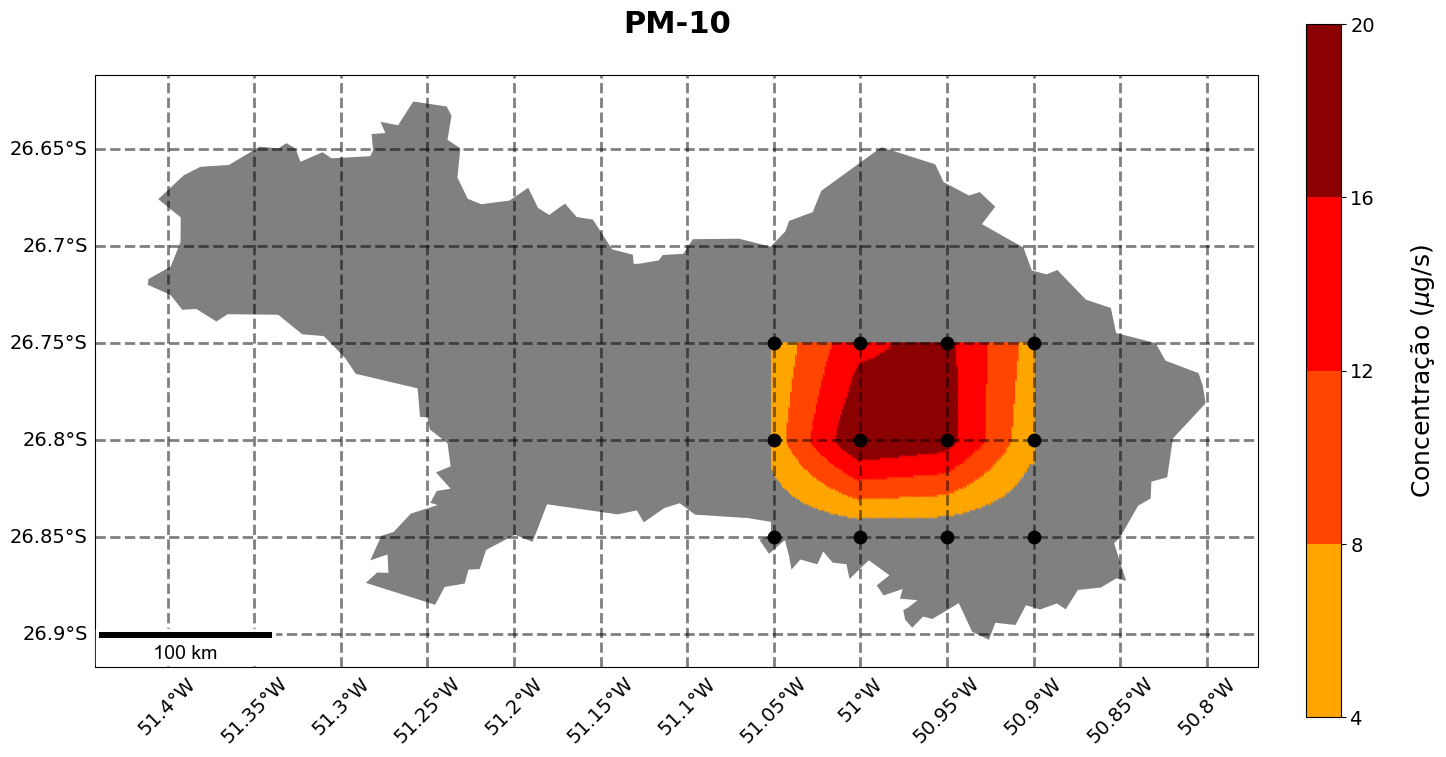

In [8]:
# Criando figura 
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()), 
                       figsize=(16.5, 9))
shape.plot(ax=ax, color='grey')
gdf1.plot(ax=ax, column='conc', cmap=cmap, markersize=10)
gdf.plot(ax=ax, column='conc', color='black', markersize=80)

# Grid
LAT, LON = np.arange(-26.90, -26.60, 0.05), np.arange(-51.5, -50.79, 0.05)
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, 
                  color='black', 
                  alpha=0.5, 
                  linestyle='--')
gl.xlocator = mticker.FixedLocator(LON)
gl.ylocator = mticker.FixedLocator(LAT)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.top_labels = False
gl.right_labels = False 
gl.xlabel_style = {'size': 14, 'rotation': 45}
gl.ylabel_style = {'size': 14}

# Colorbar
norm = mpl.colors.Normalize(vmin=4,vmax=20)
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])
cbar=plt.colorbar(sm, ticks=np.linspace(4,20,5), ax=ax,
                  fraction=0.04, anchor=(-1,0))
cbar.ax.tick_params(labelsize=14)
cbar.set_label('\nConcentração ($\mu$g/s)', fontsize=18)

# Escala
ax.add_artist(ScaleBar(dx=1,
                       units="km",
                       length_fraction=0.15,
                       scale_formatter=lambda value, unit: f' {value} km ',
                       font_properties={"family": "arial", "size": "14"},
                       location='lower left'))

plt.title('PM-10\n', weight='bold', fontsize=22)

plt.show()